In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')   # Check wether gpu is available

### The Mandelbrot set
The Mandelbrot set is a two-dimensional set that is defined in the complex plane as the complex numbers $c$ for which the function $f_c(z) = z^2 + c $ does not diverge to infinity when iterated starting at $z=0$.

Interesting properties:
- A point c belongs to the Mandelbrot set iff $|z| \leq 2$ for all $n \geq 0$

### Representing complex numbers

To represent the complex numbers, I will use an array of two float, where the first element represents the real part and the second element the imaginary part.

In [3]:
def square(x):
    result = [0, 0]

    result[0] = x[0]**2 - x[1]**2
    result[1] = 2 * x[0] * x[1]

    return result


def compute(c, z):
    """Compute z^2 + c"""
    z_square = square(z)
    return [c[0] + z_square[0] , c[1] + z_square[1]]


def isInMandelbrotSet(c, z=[0, 0], max_iter=1000, n=0) -> bool:
    if z[0]**2 + z[1]**2 > 4:
        return False
    
    if n==max_iter:
        return True

    return isInMandelbrotSet(c, compute(c, z), max_iter, n+1)


In [4]:
print(f"Is [-1,0] in the set?: {isInMandelbrotSet([-1, 0])}")  # should be true
print(f"Is [1,0] in the set?: {isInMandelbrotSet([1, 0])}")  # should be false

Is [-1,0] in the set?: True
Is [1,0] in the set?: False


### Creating a dataset

In [5]:
# Define the range for the real and imaginary parts
real_range = np.linspace(-2, 1, 250)
imag_range = np.linspace(-1.5, 1.5, 250)

data = []
for a in real_range:
    for b in imag_range:
        c = [a, b]
        is_in_set = isInMandelbrotSet(c)
        data.append({
            'real': a,
            'imag': b,
            'in_mandelbrot_set': is_in_set
        })

df = pd.DataFrame(data)

In [6]:
df

,real,imag,in_mandelbrot_set
0,-2.0,-1.500000,False
1,-2.0,-1.487952,False
2,-2.0,-1.475904,False
3,-2.0,-1.463855,False
4,-2.0,-1.451807,False
...,...,...,...
62495,1.0,1.451807,False
62496,1.0,1.463855,False
62497,1.0,1.475904,False
62498,1.0,1.487952,False


As we can see, the dataset is heavily imbalanced. It is very important to remember this, because it will affect the way we measure the performance pf the model and the way we split the dataset.

In [7]:
df['in_mandelbrot_set'].value_counts()

in_mandelbrot_set
False    52072
True     10428
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["in_mandelbrot_set"])
y = df["in_mandelbrot_set"]

# Using stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True
)

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)


### Neural Network

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, num_hidden_layers=3):
        super().__init__()
        
        layers = [
            nn.Linear(2, 32),
            nn.ReLU(),
        ]

        for _ in range(num_hidden_layers):
            layers.append(
                nn.Linear(32, 32)
            )
            layers.append(
                nn.ReLU()
            )
        
        # Output
        layers.append(
            nn.Linear(32, 1)
        )
        self.sigmoid_layer = nn.Sigmoid()
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = self.network(x)
        return self.sigmoid_layer(x)

### Visualization Function

In [15]:
def plot_decision_boundary(model, epoch, real_res=400, imag_res=400):
    """
    Generates and saves an image of the model's decision boundary.
    """
    # Define the range for the real and imaginary parts
    real_range = np.linspace(-2, 1, real_res)
    imag_range = np.linspace(-1.5, 1.5, imag_res)
    
    # Create a grid of points
    grid = []
    for a in real_range:
        for b in imag_range:
            grid.append([a, b])
            
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    model.to(device)
    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        grid_tensor = grid_tensor.to(device)
        # Get the model's predictions (probabilities)
        predictions = model(grid_tensor)
    
    # Reshape the predictions back into a 2D image format
    image_data = predictions.cpu().numpy().reshape((real_res, imag_res))
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image_data.T, extent=[-2, 1, -1.5, 1.5], origin='lower', cmap='hot')
    plt.title(f'Decision Boundary at Epoch {epoch+1}')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    
    # Save the figure to a file
    filename = f"images/mandelbrot_epoch_{epoch+1}.png"
    plt.savefig(filename)
    # plt.close()
    print(f"Saved image: {filename}")


### Training Loop

In [11]:
from torch.utils.data import TensorDataset, DataLoader

def train(model, X_train, y_train, X_val, y_val, num_epoch=20, batch_size=16, lr=0.0001, criterion=nn.BCELoss(), visualize=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Load model into GPU
    model.to(device)
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    # Convert data to PyTorch tensors
    X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1) # Convert target to float and unsqueeze for BCEWithLogitsLoss

    # Create a TensorDataset and DataLoader
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epoch):
        model.train() # Set the model to training mode
        train_loss = 0
        for batch_X, batch_y in train_loader:
            # Load into GPU
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * batch_X.size(0)
        
        model.eval() # Set the model to training mode
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                # Load into GPU
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_val_loss = val_loss / len(val_loader.dataset)
        
        # Store losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        print(f"Epoch: {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
        
        # Plotting the set
        if visualize:
            if (epoch + 1) % 10 == 0:    # Every 10 epoch
                plot_decision_boundary(model, epoch)

    # Plot the learning curves
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Learning Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

### Testing Loop

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

def test(model, X_test, y_test, threshold=0.5):
    # Convert data to Pytorch tensors
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    model.to(device)
    # Evaluation mode
    model.eval() 

    with torch.no_grad():
        # Load into GPU
        X_test_tensor = X_test_tensor.to(device)
        y_prob_tensor = model(X_test_tensor)
        
        # Convert probabilities to binary predictions (0 or 1)
        y_pred = (y_prob_tensor > threshold).float()

        y_true_np = y_test_tensor.cpu().numpy()
        y_pred_np = y_pred.cpu().numpy()
        y_prob_np = y_prob_tensor.cpu().numpy()

        # Calculate metrics
        auc = roc_auc_score(y_true_np, y_prob_np)
        print(f"Test AUC: {auc:.4f}\n")
        
        accuracy = accuracy_score(y_true_np, y_pred_np)
        print(f"Test Accuracy: {accuracy:.4f}\n")
        
        print("Classification Report:")
        print(classification_report(y_true_np, y_pred_np))
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_true_np, y_pred_np))

        f1 = f1_score(y_true_np, y_pred_np, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y_true_np, y_pred_np).ravel()

        report = {
            "accuracy": accuracy,
            "f1_score_positive": f1,
            "auc": auc,
            "true_positives": tp,
            "false_positives": fp,
            "true_negatives": tn,
            "false_negatives": fn
        }
    
    return report

### Choosing Model

We will use the validation set to test the different models and choose which one we want to use.

In [13]:
model_configs = {
    "1_hidden_layer": NeuralNet(num_hidden_layers=1),
    "3_hidden_layers": NeuralNet(num_hidden_layers=3),
    "5_hidden_layers": NeuralNet(num_hidden_layers=5),
    "7_hidden_layers": NeuralNet(num_hidden_layers=7),
    "9_hidden_layers": NeuralNet(num_hidden_layers=9),
}

results = {}

for name, model in model_configs.items():
    print(f"Training model: {name}")
    
    # Train the model
    trained_model = train(model, X_train, y_train, X_val, y_val, num_epoch=25)
    
    # Test the model and store the returned metrics
    results[name] = test(trained_model, X_val, y_val)

Training model: 1_hidden_layer
Epoch: 1, Train Loss: 0.3865911610014298, Val Loss: 0.26739500192006427
Epoch: 2, Train Loss: 0.19362022789821906, Val Loss: 0.13657498420476913


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results).T
results_df

,accuracy,f1_score_positive,auc,true_positives,false_positives,true_negatives,false_negatives
1_hidden_layer,0.890000,0.492308,0.987560,16.0,0.0,251.0,33.0
3_hidden_layers,0.960000,0.880000,0.989674,44.0,7.0,244.0,5.0
5_hidden_layers,0.960000,0.884615,0.992357,46.0,9.0,242.0,3.0
7_hidden_layers,0.960000,0.886792,0.992357,47.0,10.0,241.0,2.0
9_hidden_layers,0.963333,0.893204,0.992601,46.0,8.0,243.0,3.0


### Test the chosen architecture

Test it on the test set

Epoch: 1, Train Loss: 0.6303691384371589, Val Loss: 0.6187068144480388
Epoch: 2, Train Loss: 0.5964017956397113, Val Loss: 0.5604817954699198
Epoch: 3, Train Loss: 0.4802093390156241, Val Loss: 0.411441445350647
Epoch: 4, Train Loss: 0.39407617926597593, Val Loss: 0.3908215697606405
Epoch: 5, Train Loss: 0.3792044521079344, Val Loss: 0.37773646593093874
Epoch: 6, Train Loss: 0.36469890622531664, Val Loss: 0.36249244848887124
Epoch: 7, Train Loss: 0.34747684107107274, Val Loss: 0.3445785689353943
Epoch: 8, Train Loss: 0.32725898390307145, Val Loss: 0.32341056744257607
Epoch: 9, Train Loss: 0.3027597888427622, Val Loss: 0.2973542086283366
Epoch: 10, Train Loss: 0.27367795849547666, Val Loss: 0.2667470967769623
Epoch: 11, Train Loss: 0.2441570092474713, Val Loss: 0.23844237049420675
Epoch: 12, Train Loss: 0.21884005695581435, Val Loss: 0.21492872993151346
Epoch: 13, Train Loss: 0.20222142456208958, Val Loss: 0.20124470512072246
Epoch: 14, Train Loss: 0.1921365760880358, Val Loss: 0.192044

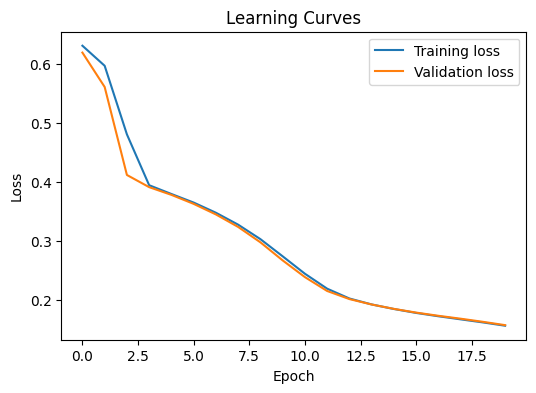

Test AUC: 0.9712

Test Accuracy: 0.9380

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96       419
         1.0       0.80      0.83      0.81        81

    accuracy                           0.94       500
   macro avg       0.88      0.89      0.89       500
weighted avg       0.94      0.94      0.94       500

Confusion Matrix:
[[402  17]
 [ 14  67]]


In [ ]:
model = NeuralNet(num_hidden_layers=5).to(device)

model = train(model, X_train, y_train, X_val, y_val)
report = test(model, X_test, y_test)

### Visualization

Epoch: 1, Train Loss: 0.25649129396089737, Val Loss: 0.08605708912025826
Epoch: 2, Train Loss: 0.08333993061047514, Val Loss: 0.06745159080879919
Epoch: 3, Train Loss: 0.073894844410689, Val Loss: 0.06105030498273748
Epoch: 4, Train Loss: 0.06872775917716546, Val Loss: 0.05710769337709547
Epoch: 5, Train Loss: 0.06542135438545284, Val Loss: 0.05459803401667208
Epoch: 6, Train Loss: 0.06320205478339819, Val Loss: 0.052954272810849704
Epoch: 7, Train Loss: 0.06153439847531207, Val Loss: 0.05182231277663814
Epoch: 8, Train Loss: 0.06033832729991449, Val Loss: 0.05111366638110703
Epoch: 9, Train Loss: 0.059360118473706855, Val Loss: 0.05047370075521831
Epoch: 10, Train Loss: 0.05847142087285296, Val Loss: 0.04991779291221998
Saved image: images/mandelbrot_epoch_10.png
Epoch: 11, Train Loss: 0.057707394750059565, Val Loss: 0.04948879553330917
Epoch: 12, Train Loss: 0.05701478414480805, Val Loss: 0.04912467360932302
Epoch: 13, Train Loss: 0.05639642542255308, Val Loss: 0.04877336158494679
Ep

KeyboardInterrupt: 

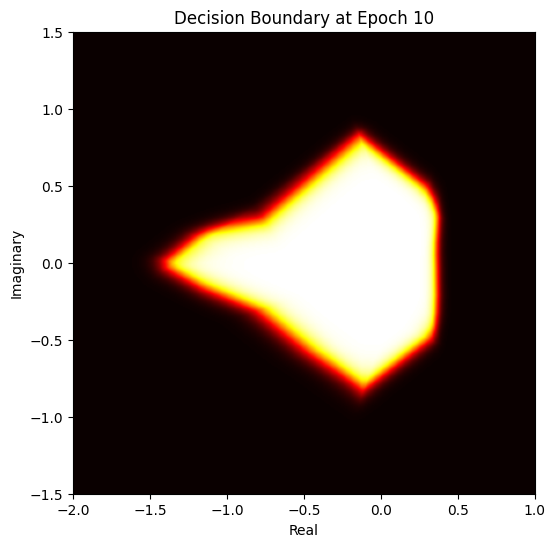

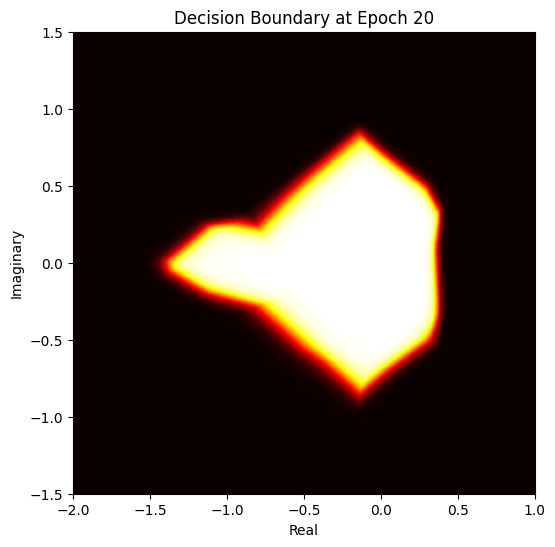

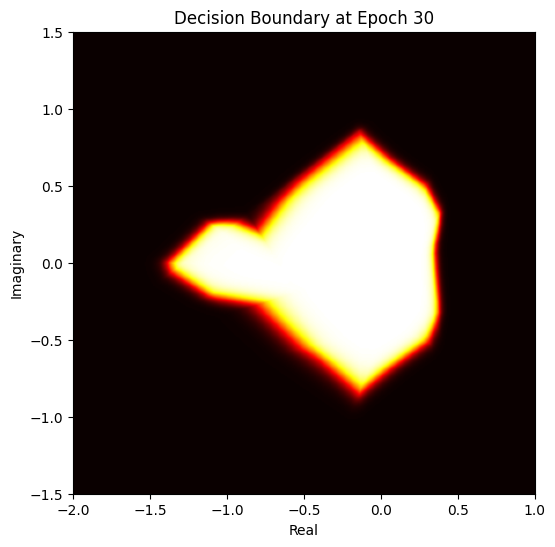

In [16]:
vis_model = NeuralNet(num_hidden_layers=5)

trained_vis_model = train(
    vis_model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epoch=125,
    visualize=True
)

print("\nVisualization complete!")